In [0]:
from pyspark.sql.session import SparkSession
from matplotlib import pyplot as plt
from operator import add
import csv

# Creating SparkSession
spark.rdd = SparkSession(sc)

In [0]:
# Copying file "clinicaltrial_2020.zip" from DBFS to local file system for unzipping
dbutils.fs.cp("dbfs:/FileStore/tables/clinicaltrial_2023.zip", "file:/tmp/")

# Copying file "pharma.zip" from DBFS to local file system for unzipping
dbutils.fs.cp("dbfs:/FileStore/tables/pharma.zip", "file:/tmp/")

Out[83]: True

In [0]:
%sh

unzip -d /tmp/ /tmp/clinicaltrial_2023.zip
unzip -d /tmp/ /tmp/pharma.zip

Archive:  /tmp/clinicaltrial_2023.zip
  inflating: /tmp/clinicaltrial_2023.csv  
Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
# Moving required files from /tmp to /tables
dbutils.fs.mv("file:/tmp/clinicaltrial_2023.csv", "dbfs:/FileStore/tables/clinicaltrial_2023.csv")
dbutils.fs.mv("file:/tmp/pharma.csv", "FileStore/tables/pharma.csv")

Out[95]: True

In [0]:
# Defining file paths
clinicaltrial_2023 = 'dbfs:/FileStore/tables/clinicaltrial_2023.csv'
pharma = 'dbfs:/FileStore/tables/pharma.csv'

In [0]:
# # Data Cleaning and Preprocessing

# Making RDD of Clinical_trial2023 Dataset 
clinicaltrial_2023rdd = sc.textFile(clinicaltrial_2023)

# Splitting each line by tab (\t) character Because the Header Titles are delimited with tab and removing quotes from start column to end column
clinicaltrial_2023rdd = clinicaltrial_2023rdd.map(lambda line: line.split("\t"))
clinicaltrial_2023rdd = clinicaltrial_2023rdd.map(lambda cols: [cols[0].lstrip('"')] + cols[1:-1] + [cols[-1].rstrip('"').rstrip(',')])

# Removing the first row (header in DataFrame)
first_row = clinicaltrial_2023rdd.first()
clinicaltrial_2023rdd = clinicaltrial_2023rdd.zipWithIndex().filter(lambda x: x[1] > 0).map(lambda x: x[0])

In [0]:
#2.1.2 (1) Printing the Number of Distinct Studies
print(f"Number of distinct studies: {clinicaltrial_2023rdd.count()}")

Number of distinct studies: 483422


In [0]:

#2.1.2 (2) Types of Studies Alongwith their Frequencies
# Filtering the data to ensure the 'Type' column is present
filtered_rdd = clinicaltrial_2023rdd.filter(lambda x: len(x) > 10)

# Extract the 'Type' column and filter out the header
types_rdd = filtered_rdd.map(lambda y: y[10]).filter(lambda z: z != "Type")

# Count frequencies of each type
type_freq_rdd = types_rdd.map(lambda s: (s, 1)).reduceByKey(lambda x, y: x + y)

# Sort by frequency in descending order and collect the results
sorted_frequencies = type_freq_rdd.sortBy(lambda x: x[1], ascending=False).collect()

# Output the results
print("Types of Studies along with their frequencies in descending order:")
sorted_frequencies

Types of Studies along with their frequencies in descending order:
Out[99]: [('INTERVENTIONAL', 371382),
 ('OBSERVATIONAL', 110221),
 ('EXPANDED_ACCESS', 928),
 ('', 889)]

In [0]:
#2.1.2 (3) The top 5 conditions (from Conditions) with their frequencies.
# Extracting conditions and flatten them into a single RDD, and Splitting the Conditions Column by "|"
flat_conditions_rdd = clinicaltrial_2023rdd.map(lambda x: x[4]).flatMap(lambda x: x.split("|"))

# Maping each condition to a pair (condition, 1), then Reduce by key to count frequencies
conditions_frequency_rdd = flat_conditions_rdd.map(lambda condition: (condition, 1)).reduceByKey(lambda a, b: a + b)
 
# Sorting the frequencies in descending order and take the top 5
top_5_conditions = conditions_frequency_rdd.sortBy(lambda x: x[1], ascending=False).take(5)
print("Top 5 Conditions:")
top_5_conditions

Top 5 Conditions:
Out[100]: [('Healthy', 9731),
 ('Breast Cancer', 7502),
 ('Obesity', 6549),
 ('Stroke', 4071),
 ('Hypertension', 4020)]

In [0]:
# 2.1.2 (4) Find the 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored.
# Load the pharmaceutical company names from a CSV file
pharma_rdd = sc.textFile("/FileStore/tables/pharma.csv")
header = pharma_rdd.first()  # Extract header to skip it in the next step

# Assuming 'Parent_Company' is the second column in the CSV
pharma_companies = pharma_rdd \
    .filter(lambda line: line != header) \
    .map(lambda line: line.split(",")[1].strip('" ')) \
    .distinct() \
    .collect()

# Create a set of pharmaceutical company names for efficient lookup
pharma_companies_set = set(pharma_companies)

# Filter out trials sponsored by pharmaceutical companies from the clinical trials RDD
# Assuming 'Sponsor' is at index 6 in clinical_trials_data_rdd
non_pharma_trials_rdd = clinicaltrial_2023rdd \
    .filter(lambda x: x[6] not in pharma_companies_set)

# Count occurrences of each non-pharmaceutical sponsor
sponsor_count_rdd = non_pharma_trials_rdd \
    .map(lambda x: (x[6], 1)) \
    .reduceByKey(lambda x, y: x + y)

# Sort by count in descending order and take the top 10
top_10_sponsors = sponsor_count_rdd \
    .sortBy(lambda x: x[1], ascending=False) \
    .take(10)

# Print the top 10 non-pharmaceutical sponsors
print("Top 10 non-pharmaceutical sponsors:")
top_10_sponsors

Top 10 non-pharmaceutical sponsors:
Out[101]: [('National Cancer Institute (NCI)', 3410),
 ('Assiut University', 3335),
 ('Cairo University', 3023),
 ('Assistance Publique - Hôpitaux de Paris', 2951),
 ('Mayo Clinic', 2766),
 ('M.D. Anderson Cancer Center', 2702),
 ('Novartis Pharmaceuticals', 2393),
 ('National Institute of Allergy and Infectious Diseases (NIAID)', 2340),
 ('Massachusetts General Hospital', 2263),
 ('National Taiwan University Hospital', 2181)]

In [0]:
# 2.1.2 (5) Plotting number of completed studies for each month in 2023

import matplotlib.pyplot as plt
# Filtering out completed studies in 2023 from the RDD
completedStudies2023RDD = clinicaltrial_2023rdd.filter(lambda row: row[3] == "COMPLETED" and row[-1][:4] == '2023')
# Maping to pair RDD with month as key and 1 as initial count
monthlyCompletedStudiesRDD = completedStudies2023RDD.map(lambda row: (row[-1][5:7], 1))
# using Reduce by key to count studies per month and sort by month
monthlyStudyCountsRDD = monthlyCompletedStudiesRDD.reduceByKey(lambda a, b: a + b).sortByKey()
monthlyStudyCounts = monthlyStudyCountsRDD.collect()
# Extracting months and counts for plotting
months, studyCounts = zip(*monthlyStudyCounts)

# Displaying the table of monthly completed studies
print("Month\tNumber of Completed Studies")
for month, count in monthlyStudyCounts:
    print(f"{month}\t\t{count}")

Month	Number of Completed Studies
01		1494
02		1272
03		1552
04		1324
05		1415
06		1619
07		1360
08		1230
09		1152
10		1058
11		909
12		1082


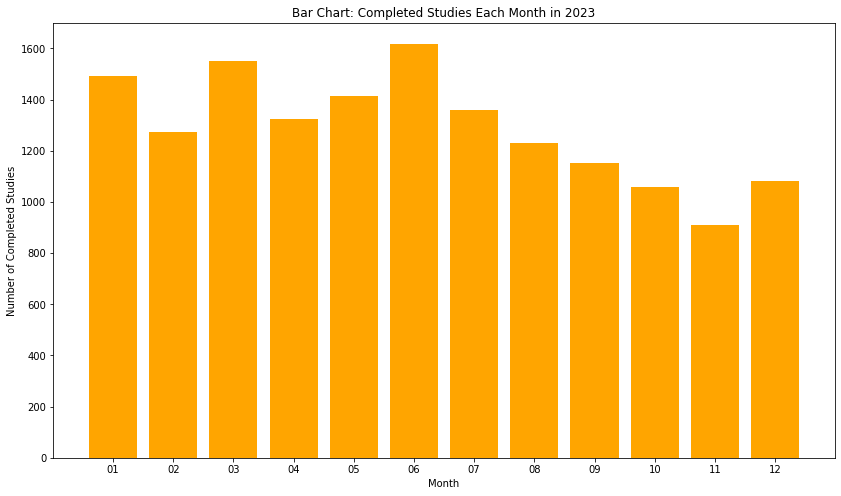

In [0]:

# 2.1.2 (5) Plotting setup
# Bar Chart
plt.figure(figsize=(14, 8))
plt.bar(months, studyCounts, color='Orange')
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.title('Bar Chart: Completed Studies Each Month in 2023')
plt.xticks(months)
plt.show()

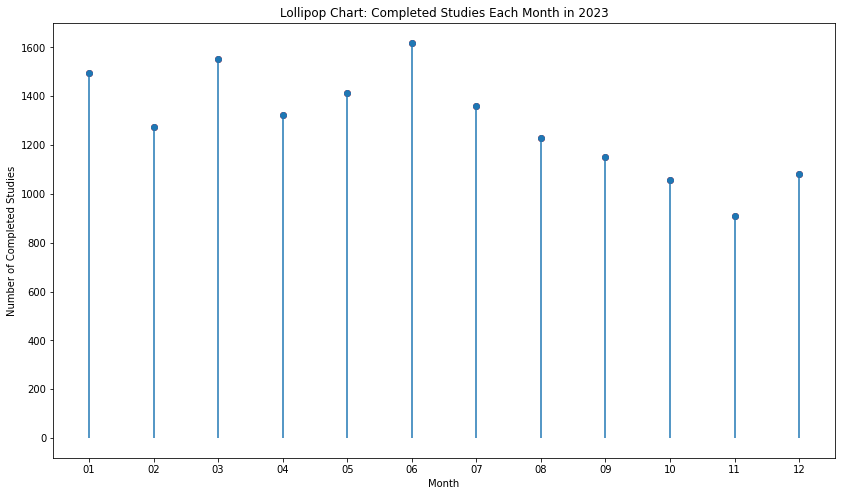

In [0]:
# 2.1.2 (5) Plotting setup
# Lollipop Chart
plt.figure(figsize=(14, 8))
plt.stem(months, studyCounts, basefmt=" ", use_line_collection=True) 
plt.scatter(months,studyCounts, color='red')
plt.xlabel('Month')
plt.ylabel('Number of Completed Studies')
plt.title('Lollipop Chart: Completed Studies Each Month in 2023')
plt.xticks(months)
plt.show()

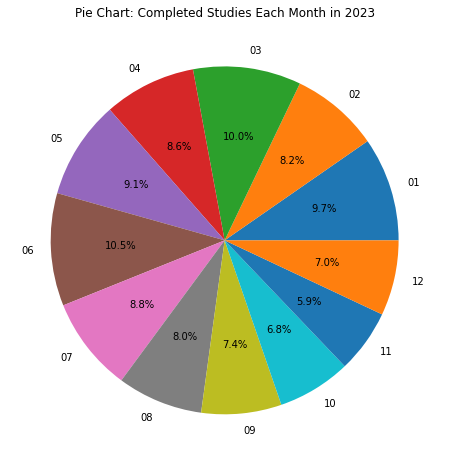

In [0]:
# 2.1.2 (5) Plotting setup
# Pie Chart
plt.figure(figsize=(14, 8))
plt.pie(studyCounts, labels=months, autopct='%1.1f%%')
plt.title('Pie Chart: Completed Studies Each Month in 2023')
plt.show()

In [0]:
# Further Analysis Number 1
# Distribution of Funder types with frequencies

# Extracting funder types and counting their frequencies
funder_type_rdd = filtered_rdd.map(lambda y: (y[9], 1))

# Counting frequencies of each funder type
funder_freq_rdd = funder_type_rdd.reduceByKey(lambda x, y: x + y)

# Sorting by frequency in descending order and collecting results
sorted_funder_frequencies = funder_freq_rdd.sortBy(lambda x: x[1], ascending=False).collect()

# Output the results
print("Distribution of Funder Types:")
sorted_funder_frequencies


Distribution of Funder Types:
Out[106]: [('OTHER', 336305),
 ('INDUSTRY', 113048),
 ('OTHER_GOV', 12377),
 ('NIH', 11193),
 ('FED', 4526),
 ('NETWORK', 4410),
 ('', 889),
 ('INDIV', 575),
 ('UNKNOWN', 94),
 ('AMBIG', 3)]

In [0]:
# Further Analysis Number 2

# Top 10 Study Statuses by their frequencies
# Extracting study statuses and counting their frequencies
status_rdd = filtered_rdd.map(lambda y: (y[3], 1))

# Counting frequencies of each study status
status_freq_rdd = status_rdd.reduceByKey(lambda x, y: x + y)

# Sorting by frequency in descending order
sorted_status_frequencies = status_freq_rdd.sortBy(lambda x: x[1], ascending=False)

# Taking the top 10
top_10_status_frequencies = sorted_status_frequencies.take(10)

# Output the results
print("Top 10 Study Statuses by Frequency:")
top_10_status_frequencies


Top 10 Study Statuses by Frequency:
Out[107]: [('COMPLETED', 263497),
 ('RECRUITING', 66158),
 ('UNKNOWN', 64813),
 ('TERMINATED', 28022),
 ('NOT_YET_RECRUITING', 20098),
 ('ACTIVE_NOT_RECRUITING', 19716),
 ('WITHDRAWN', 13718),
 ('ENROLLING_BY_INVITATION', 3937),
 ('SUSPENDED', 1644),
 ('WITHHELD', 889)]